# Spectral Analysis & Mesh Reconstruction

## Boilerplate Code

In [26]:
import os, sys
sys.path.append(os.getcwd())
sys.path.append(os.getcwd() + '/..')
sys.path.append(os.getcwd() + '/../..')
sys.path.append(os.getcwd() + '/../lib')
sys.path.append(os.getcwd() + '/../../lib')

from vtkplotter import *
embedWindow(backend="k3d")

from lib.mesh_util import load_triangular_mesh, present_mesh
from lib.laplacian_operations import *
from lib.laplacian_beltrami import LaplaceBeltramiWeighting
from vtkplotter import *
from trimesh import Trimesh
import numpy as np
from scipy import sparse

print('Demo Ready.')

Demo Ready.


## Available Meshes

In [27]:
root_dir = f"{os.getcwd()}/../.."
OLAF = f"{root_dir}/models/olafdidofranza/File/OBj/Studio Pose OLAF.obj"
BATMAN = f"{root_dir}/models/batman/batman.obj"
TEAPOT = f"{root_dir}/models/teapot/teapot.obj"
DEER = f"{root_dir}/models/lowpolydeer/deer.obj"
HUMAN = f"{root_dir}/models/human/sculpt.obj"
OGRE = f"{root_dir}/models/ogre/OgreOBJ.obj"
GOOFY_GORGON = f"{root_dir}/models/gorgon/17902_Goofy_Gorgon_V1.obj"
LIBRARIAN = f"{root_dir}/models/librarian/Librarian.obj"


mesh_path = LIBRARIAN

## Default Mesh

In [28]:
embedWindow(backend="k3d")
mesh = load_triangular_mesh(mesh_path, keep_only_largest_component=False)
show(mesh, viewup="y")

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[3.811880448555929,…

## Eigendecomposition

Set K to the number of eigenvalues the decomposition should yield (setting too high of a number may crash the app).

In [29]:
K = 430
weighting_scheme = LaplaceBeltramiWeighting.COTANGENT_NO_AREA

In [30]:
import numpy as np

mesh = load_triangular_mesh(mesh_path, keep_only_largest_component=False)
eigvalues, eigvectors = spectral_decomposition(mesh, weighting_scheme, K, eps=1e-14)

print('Eigen-decomposition complete - proceed to the rest of the demo.')

Eigen-decomposition complete - proceed to the rest of the demo.


## Spectral Analysis

### Eigenvalues

The following plot shows the magnitude of the Laplacian's eigenvalues, in ascending order.

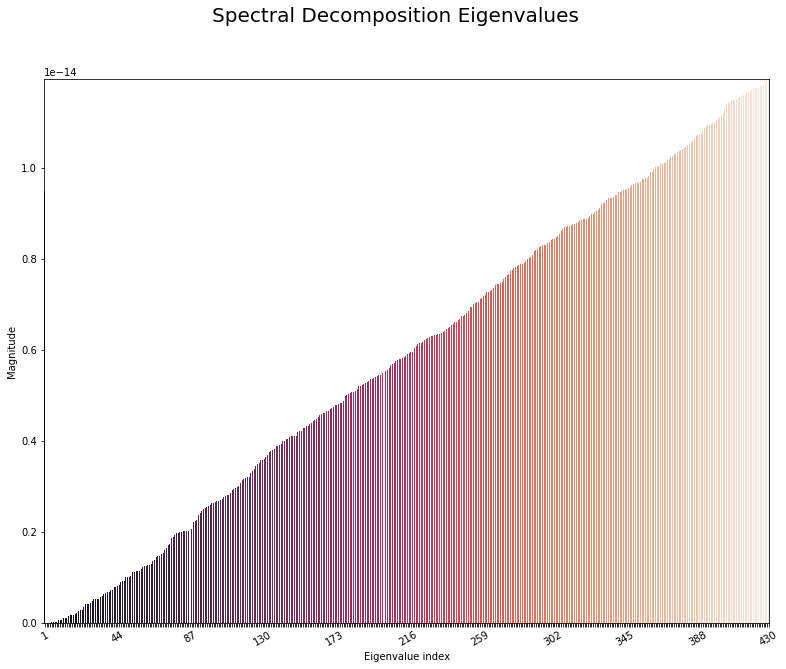

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

# sns.set(style="white", context="talk")
f, ax = plt.subplots(1, 1, figsize=(13, 10))
x = np.arange(1,len(eigvalues) + 1)
y = np.abs(eigvalues)
g = sns.barplot(x=x, y=y, palette="rocket", ax=ax)
ax.set_ylabel("Magnitude")
ax.set_xlabel("Eigenvalue index")

x_tick_values = np.linspace(min(x), max(x)+1, 10, dtype=int)

labels = ax.get_xticklabels() # get x labels
for i,l in enumerate(labels[:-1]):
    if(i%(K//10) != 0):
        labels[i] = '' # skip even labels
ax.set_xticklabels(labels, rotation=30) # set new labels

plt.ticklabel_format(style='sci', axis='y')

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .59)
f.suptitle('Spectral Decomposition Eigenvalues', fontsize=20)
plt.show()

### Eigenvectors

Visualization of Laplacian spectral decomposition. <br>
Tweak the slider to view the various eigenvectors composing the Fourier basis of the Laplacian matrix. <br>

In [32]:
import k3d
from ipywidgets import interact, interactive, fixed, IntSlider, Dropdown
import ipywidgets as widgets
import vtk
from vtkplotter import colors

cmap = 'winter'
lut = []
for i in range(256):
    r, g, b = colors.colorMap(i, cmap, 0, 256)
    lut.append((i, r, g, b))

embedWindow(backend="k3d")
plot = k3d.plot()
mesh = load_triangular_mesh(mesh_path, keep_only_largest_component=False)
mesh_vtk = trimesh2vtk(mesh)
eigven_field = eigvectors[:,1]
mesh_vtk.pointColors(eigven_field, cmap=cmap, mode="scalars")
mesh_k3d = k3d.vtk_poly_data(mesh_vtk.polydata(),
                             color_attribute=('pointColors_winter', np.min(eigven_field), np.max(eigven_field)),
                             color_map=lut)
plot += mesh_k3d

eigenvector_id = IntSlider(min=0,max=K-1,step=1, continuous_update=False,
                                     layout={'width': '900px'}, description='eigenvector_id:',
                                     style = {'description_width': 'initial'})
def on_slider_change(params):
    global mesh_k3d, mesh, plot, mesh_vtk
    eigenvector_id = params['new']
    eigven_field = eigvectors[:,eigenvector_id]    
    
    camera = plot.camera
    plot.camera_auto_fit = False    
    plot -= mesh_k3d
    mesh_vtk.pointColors(eigven_field, cmap=cmap, mode="scalars")    
    mesh_k3d = k3d.vtk_poly_data(mesh_vtk.polydata(),
                                 color_attribute=('pointColors_winter', np.min(eigven_field), np.max(eigven_field)),
                                 color_map=lut)
    plot += mesh_k3d
    plot.camera = camera

    
eigenvector_id.observe(on_slider_change, 'value')
display(eigenvector_id)

if mesh_path == LIBRARIAN:
    plot.camera_auto_fit = False      
    plot.camera = [-0.9836856115441313, 129.89389850777974, 272.0423783356993,
                   7.705028633402967, 123.96748549648429, 11.550819621676315,
                   -0.026766749427716813, 0.9991355868202794, 0.031805978594613794]
plot.display()

IntSlider(value=0, continuous_update=False, description='eigenvector_id:', layout=Layout(width='900px'), max=4…

Output()

## Mesh Reconstruction

This Mesh Reconstruction scheme uses the first M eigenvectors to rebuild the mesh. <br>
First Laplacian-Beltrami is constructed and decomposed to M eigenvectors, denoted by L_M. <br>
Then, the reconstructed mesh is calculated by L_M @ L_M^T @ v  (where @ denotes matrix multiplication, ^T denotes transposition)

In [33]:
import k3d
from ipywidgets import interact, interactive, fixed, IntSlider, Dropdown
import ipywidgets as widgets


plot_r = k3d.plot()
mesh_k3d_r = k3d.vtk_poly_data(trimesh2vtk(mesh).polydata(), color=0x555555)
plot_r += mesh_k3d_r
plot_r.display()


vecs_count_to_use = IntSlider(min=1,max=K-1,step=1, continuous_update=False,
                              layout={'width': '900px'}, description='#vectors to use:',
                              style = {'description_width': 'initial'})
def on_vec_count_slider_change(params):
    global mesh_k3d_r, mesh, plot_r
    vecs_count = params['new']
    
    camera = plot_r.camera
    plot_r.camera_auto_fit = False    
    plot_r -= mesh_k3d_r
    
    mesh_to_reconstruct = mesh_reconstruct(mesh, eigvectors, vec_count_to_use=vecs_count)
    mesh_k3d_r = k3d.vtk_poly_data(trimesh2vtk(mesh_to_reconstruct).polydata(), color=0x555555)
    plot_r += mesh_k3d_r
    plot_r.camera = camera

    
vecs_count_to_use.observe(on_vec_count_slider_change, 'value')
display(vecs_count_to_use)

if mesh_path == LIBRARIAN:
    plot_r.camera_auto_fit = False      
    plot_r.camera = [-0.9836856115441313, 129.89389850777974, 272.0423783356993,
                   7.705028633402967, 123.96748549648429, 11.550819621676315,
                   -0.026766749427716813, 0.9991355868202794, 0.031805978594613794]

Output()

IntSlider(value=1, continuous_update=False, description='#vectors to use:', layout=Layout(width='900px'), max=…